# Module 4 Project - Movie Recommendation System

By: **Cary Mosley** and **Bryan Santos**

For this project, we decided to build a recommendation system for movies. We want to ensure that our models are not biased towards popular movies. We want to be able to recommend "hidden gems" based on multiple criteria. Our goal is to build a hybrid model that will focus on content based recommendations when we do not have enough data for a user profile and weight our recommendations more towards similar users as we gather more data about our consumers. As ratings tend to be skewed towards popular movies we want to focus on movies that have high ratings but are not simply the most popular movies.

Dataset: https://grouplens.org/datasets/movielens/100k

***

## Package Loads and Data Imports

### Import necesary packages

In [1]:

import pandas as pd
import numpy as np
import missingno as mno

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import surprise
import sklearn
import sklearn.metrics
import datetime
import nltk
import matplotlib.pyplot as plt
import string, re 

from scipy import stats
from math import log
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise import Reader, Dataset, SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from collections import defaultdict
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
lemmatizer = WordNetLemmatizer() 
from surprise import accuracy
from surprise import Reader, Dataset, SVD
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from scipy import sparse

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model, load_model as keras_load_model
from keras import losses
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
import random
from keras.models import Sequential
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from recsys import *
from lightfm.datasets import fetch_movielens



# pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/Users/Bryan/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

### Data Load and Initial Cleaning

In [3]:
#Import data files
movies_df = pd.read_csv('movies.csv',index_col=False)
ratings_df = pd.read_csv('ratings.csv',index_col=False)
tags_df = pd.read_csv('tags.csv',index_col=False)
links_df = pd.read_csv('links.csv', index_col=False)
plot_df = pd.read_csv('plot.csv', index_col=False, engine='python')

First thing is to look at each file to get an idea of what is contained. Then we will merge any relavent data sets and perform some EDA. We inspect each of the five csv files included.

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies_df = movies_df.drop_duplicates(subset=['movieId'], keep='first')

In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
ratings_df = ratings_df.drop_duplicates(subset=['movieId', 'userId'], keep='first')

In [8]:
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [9]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
links_df = links_df.drop_duplicates(subset=['movieId'], keep='first')

In [11]:
del plot_df['Unnamed: 0']
plot_df.head()

,tmdbId,plot
0,8844,When siblings Judy and Peter discover an encha...
1,15602,A family wedding reignites the ancient feud be...
2,31357,"Cheated on, mistreated and stepped on, the wom..."
3,11862,Just when George Banks has recovered from his ...
4,949,"Obsessive master thief, Neil McCauley leads a ..."


In [12]:
plot_df = plot_df.drop_duplicates(subset=['tmdbId'], keep='first')

In [13]:
movies_df.set_index('movieId')

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


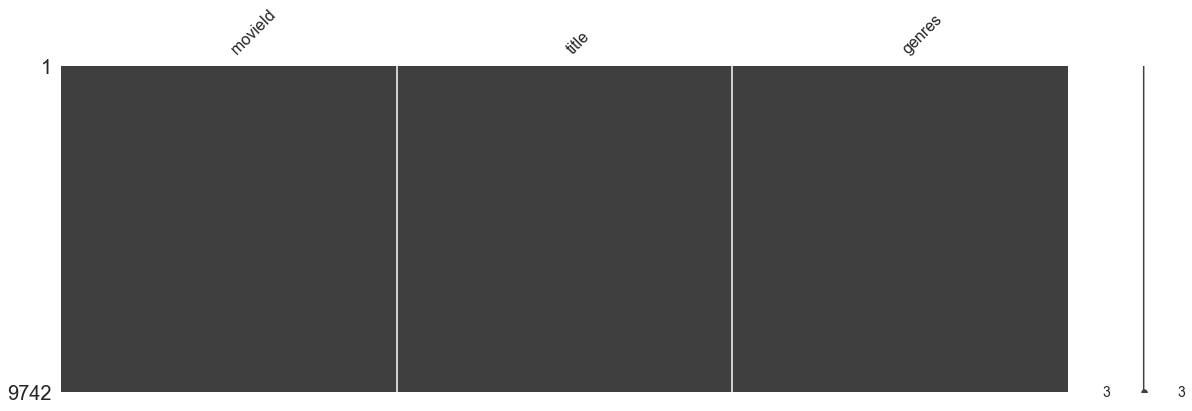

In [14]:
mno.matrix(movies_df, figsize = (20, 6))
plt.show()

No missing values for movies_df

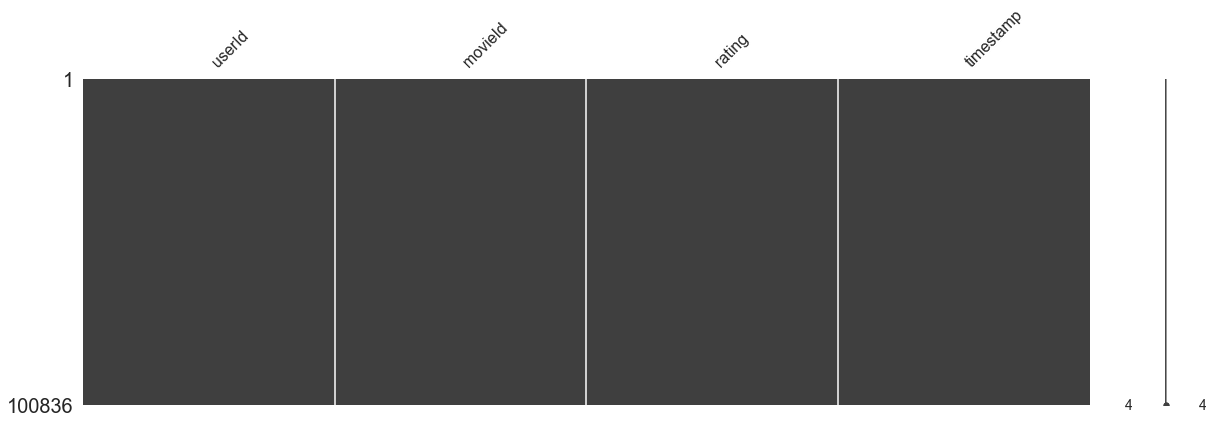

In [15]:
mno.matrix(ratings_df, figsize = (20, 6))
plt.show()

No missing values for ratings_df

In [16]:
ratings_df = ratings_df.dropna()

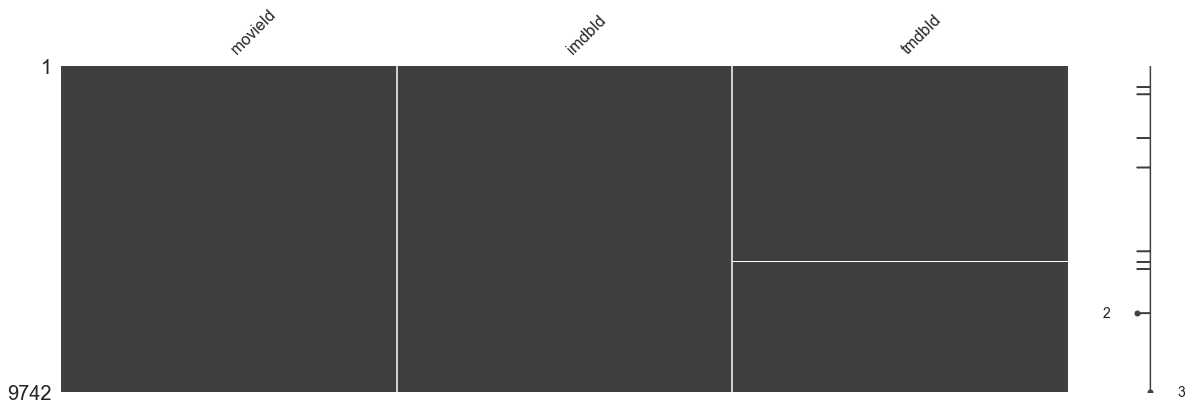

In [17]:
mno.matrix(links_df, figsize = (20, 6))
plt.show()

There is missing value in links_df. For investigation and proper action later.

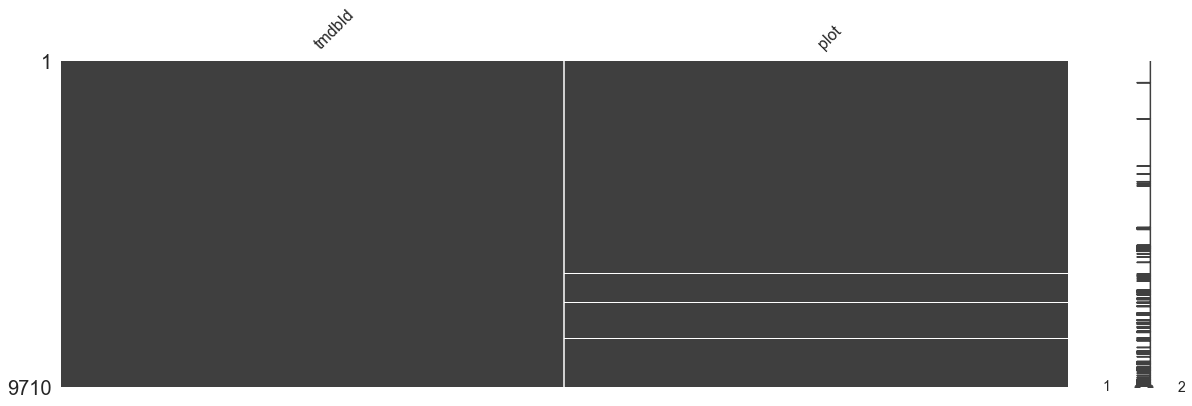

In [18]:
mno.matrix(plot_df, figsize = (20, 6))
plt.show()

There are several missing values in plot_df. For investigation and proper action later.

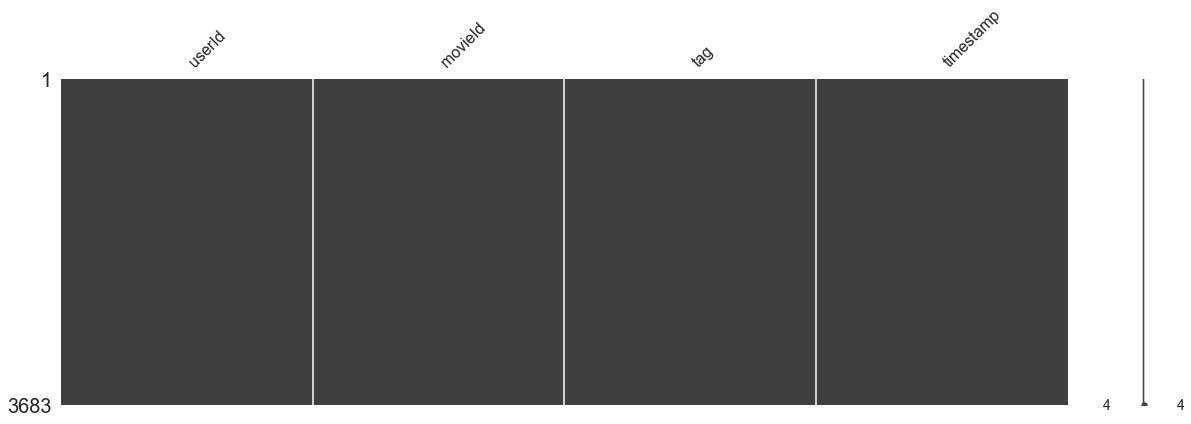

In [19]:
mno.matrix(tags_df, figsize = (20, 6))
plt.show()

There are several missing values in plot_df. For investigation and proper action later.

In [20]:
# Double check shape of each df prior to merging
print("movie df - " + str(movies_df.shape))
print("ratings df - " + str(ratings_df.shape))
print("links df - " + str(links_df.shape))
print("plot df - " + str(plot_df.shape))
print("tags df - " + str(tags_df.shape))

movie df - (9742, 3)
ratings df - (100836, 4)
links df - (9742, 3)
plot df - (9710, 2)
tags df - (3683, 4)


In [21]:
# Add IMDB/TMDB links for merging with movie plot gathered from API calls 
df = pd.merge(movies_df,links_df, on='movieId', how='left')

In [22]:
df2 = df.copy()

In [23]:
df.shape

(9742, 5)

In [24]:
df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0


In [25]:
# Merge to get each movie plot for NLP 
df = pd.merge(df,plot_df, on='tmdbId', how='left')

In [26]:
df = df.drop_duplicates(subset=['movieId'], keep='first')
df.shape

(9742, 6)

In [27]:
df = df.dropna() 
df.shape

(9594, 6)

In [28]:
nlp_df = df.copy()

In [29]:
ratings_df = ratings_df.dropna() 
ratings_df.shape

(100836, 4)

In [30]:
ratings_df = ratings_df.drop_duplicates(subset=['movieId', 'userId'], keep='first')

In [31]:
ratings_df.shape

(100836, 4)

In [32]:
#nlp_df = pd.merge(df,plot_df, on='tmdbId', how='left')

In [33]:
nlp_df

,movieId,title,genres,imdbId,tmdbId,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,"Ciel learns of a ""Aurora Society"", that is rum..."
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,"In ancient Disboard, Riku is an angry, young w..."
9739,193585,Flint (2017),Drama,6397426,479308.0,A woman deals with the toxic water scandal in ...
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0,Power users around the world are suddenly comm...


In [34]:
nlp_df = nlp_df.drop_duplicates(subset=['movieId'], keep='first')
nlp_df = nlp_df.dropna()

In [35]:
# Merge all movie details with dataset that has ratings
df = pd.merge(ratings_df,df, on="movieId", how="inner")

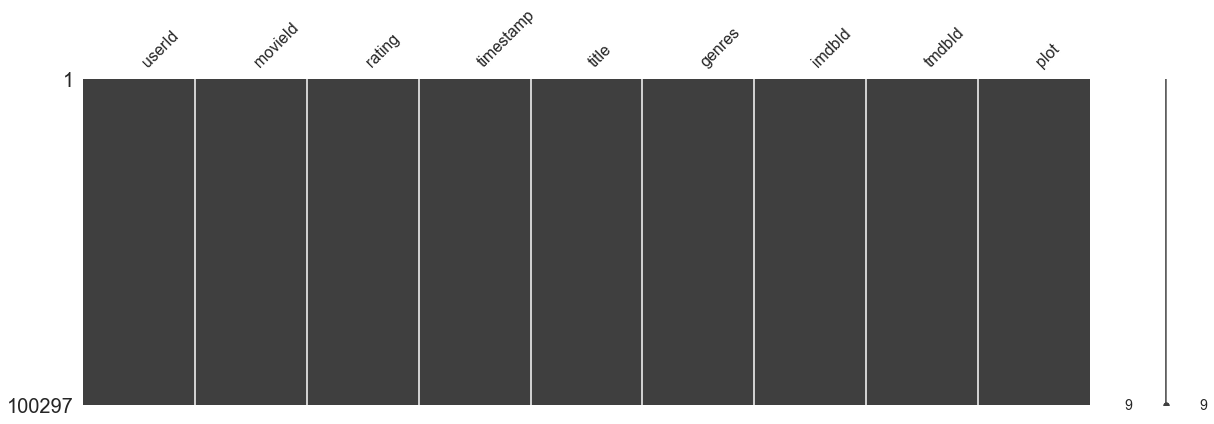

In [36]:
mno.matrix(df, figsize = (20, 6))
plt.show()

In [37]:
df = df.dropna()

In [38]:
plot_df = plot_df.dropna()

In [39]:
plot_df['plot'].nunique()

9588

In [40]:
ratings_df.to_csv("ratings_df.csv")

## EDA

### Ratings

**Count per User Rating**

The first data we'll look at is for the collaborative model will just be using the ratings dataframe

In [41]:
#Look at column types
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.8 MB


There are no null values in our dataframe

In [42]:
#Check for null values
ratings_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

**Rating Distribution**

In [43]:
ratings_df['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

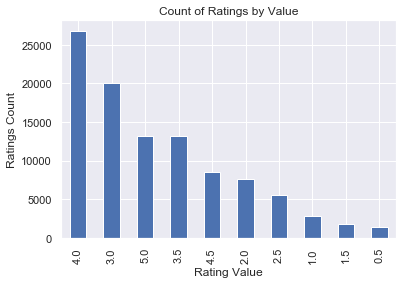

In [44]:

fig, ax = plt.subplots()
ax = ratings_df['rating'].value_counts().plot(kind='bar')
ax.set_xlabel('Rating Value')  # Add an x-label to the axes.
ax.set_ylabel('Ratings Count')  # Add a y-label to the axes.
ax.set_title("Count of Ratings by Value")  # Add a title to the axes.

plt.show()

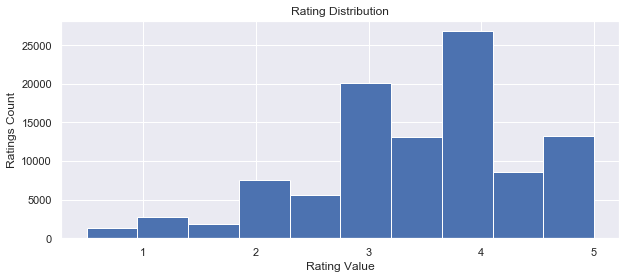

In [45]:
plt.figure(figsize=(10,4))
plt.hist(ratings_df['rating'], bins = 10)
plt.title('Rating Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Ratings Count')
ax.grid('false')

*Observations:*
    
We can see that majority of the movies are rated either 3 or 4 out of 5 stars. The ratings are skewed towards higher ratings and we can see that there are signifcantly more 5 star ratings than those in the lowest bucket.

### Users

**Distribution of User Behavior**

In [46]:
x = ratings_df['userId'].value_counts()
users = x.index[:]
counts = x.iloc[:]

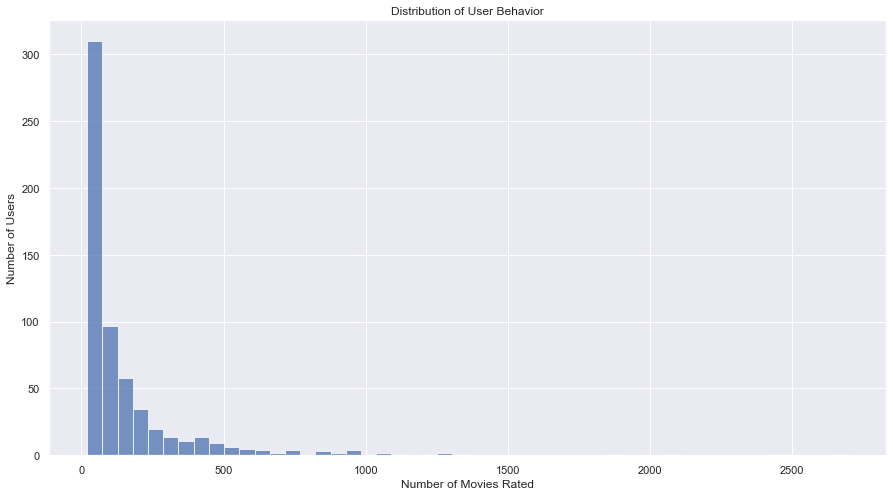

In [47]:
plt.figure(figsize=(15,8))
plt.hist(counts, 50, density=False, alpha=0.75)
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.title('Distribution of User Behavior')
plt.grid(True)
plt.show()

*Observations:*

It is strange that the vast majority of the users have reviewed very few movies. Yet, there are outliers who have reviewed more than 2,000 movies. This may present a challenge when using User-User similarity as we don't have many points of comparison for the majority of users.

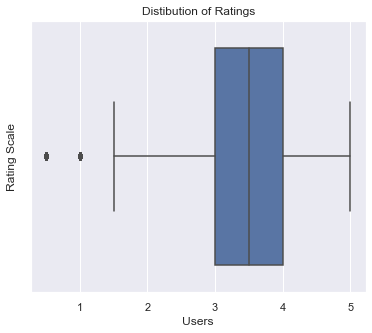

In [48]:
plt.figure(figsize=(6,5))
sns.boxplot(ratings_df['rating'])
plt.xlabel('Users')
plt.ylabel('Rating Scale')
plt.title('Distibution of Ratings')
plt.show()

*Observations:*

We see that the average rating is centred around the 3.5 and the interquartile range is between 3-4. A lot of movies have been highly rated. This may present a difficulty with Item-Item similarity as there is not enough difference in many items to form an accurate picture of the distance between them.

### Genres

We now look into the different genres of the movies reviewed. In order to that, some pre-processing is necessary because each movie has multiple genres listed. This needs to be fleshed out.

In [49]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [50]:
genres_df = splitDataFrameList(df,"genres","|")

In [51]:
genres_df.head(5)

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot
0,1,1,4.0,964982703,Toy Story (1995),Adventure,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
1,1,1,4.0,964982703,Toy Story (1995),Animation,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
2,1,1,4.0,964982703,Toy Story (1995),Children,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
3,1,1,4.0,964982703,Toy Story (1995),Comedy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."
4,1,1,4.0,964982703,Toy Story (1995),Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ..."


In [52]:
genres_mean_df = genres_df.groupby('genres', as_index=False).agg({'rating': ['mean','count']})
genres_mean_df.columns = genres_mean_df.columns.droplevel(0)

In [53]:
genres_mean_df.columns = ['Genre', 'Mean', 'Count']
genres_mean_df = genres_mean_df.sort_values("Mean", ascending=False)

In [54]:
genres_mean_df.head(5)

,Genre,Mean,Count
10,Film-Noir,3.920115,870
18,War,3.808845,4771
7,Documentary,3.784810,1185
6,Crime,3.658821,16613
8,Drama,3.656194,41618


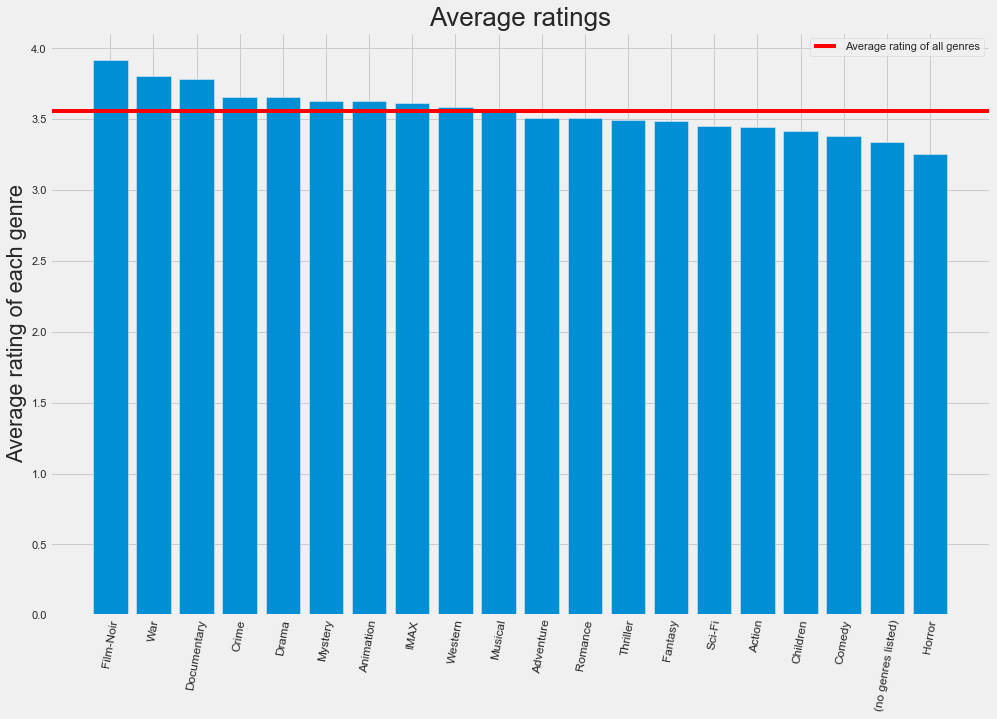

In [55]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Mean"])
ax.axhline(genres_mean_df["Mean"].mean(), color="red", label="Average rating of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average rating of each genre")
ax.set_title('Average ratings')
ax.legend()

plt.show()

*Observations:*
    
Film-Noir genre has the highest rating of all genres followed by War, Documentary and Crime. Comedy and Horror are the last placers.

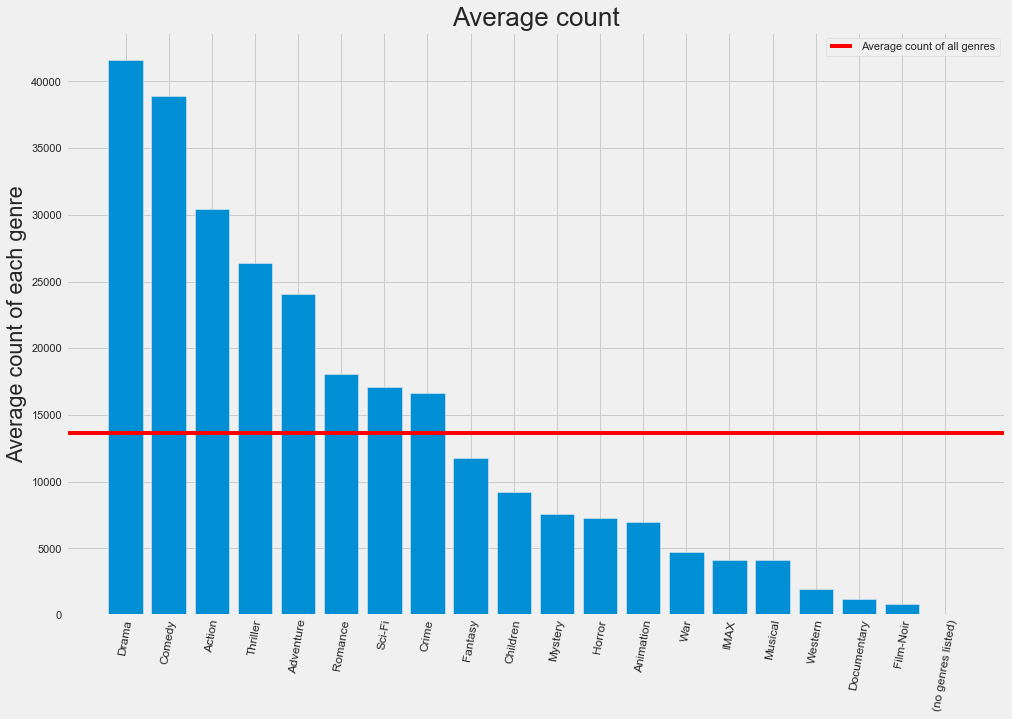

In [56]:
genres_mean_df = genres_mean_df.sort_values("Count", ascending=False)

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(genres_mean_df["Genre"],genres_mean_df["Count"])
ax.axhline(genres_mean_df["Count"].mean(), color="red", label="Average count of all genres")

ax.set_xticklabels(genres_mean_df["Genre"], rotation=80, fontsize=12)

ax.set_ylabel("Average count of each genre")
ax.set_title('Average count')
ax.legend()
plt.show()

*Observations:*

There are many more Drama movies reviewed versus other genres. The highest-reviewed genre has one of the fewest movies reviewed. Although not many people seem to watch or review Film-Noir movies they are very well regarded. This strikes us as a type of film we might want to be reccommending to people who are not discovering them on their own.

### Year

In [57]:
date = []
for i in tqdm(df['timestamp']):
    date.append(datetime.datetime.fromtimestamp(i).strftime('%Y'))

In [58]:
df['ratedYear'] = date
df.shape

(100297, 10)

In [59]:
z = df['ratedYear'].value_counts()
ycounts = z.iloc[:]
years = z.index[:]

In [60]:
year_df = pd.DataFrame({'Year':years,'counts':ycounts})
year_df.reset_index(drop =True)
year_df.sort_values(by=['Year'],inplace = True)

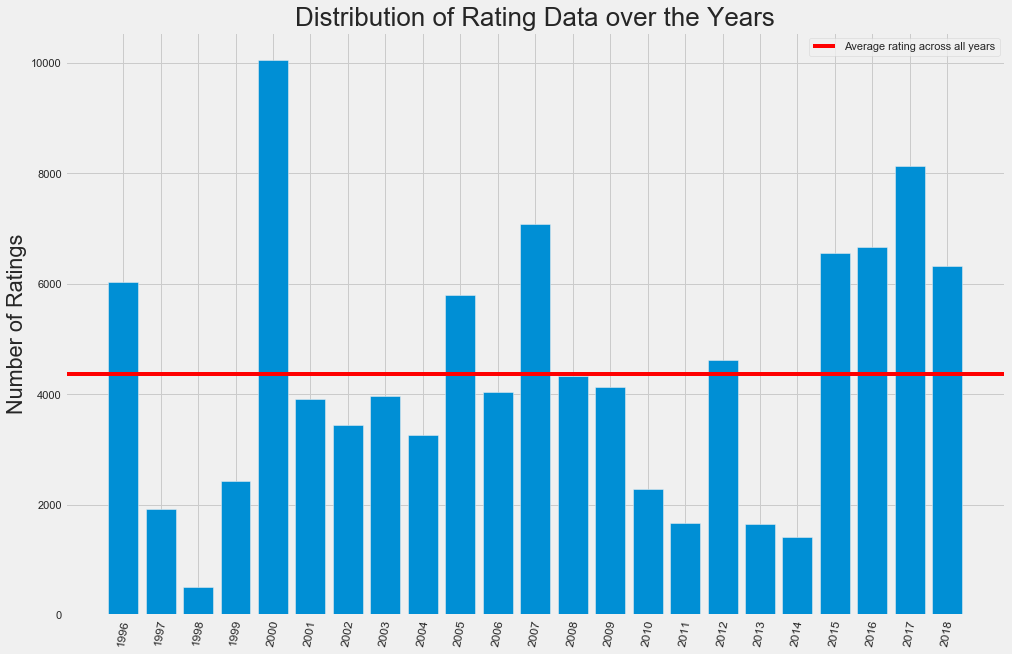

In [61]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 18})


fig, ax = plt.subplots(figsize=(15,10))

ax.bar(year_df.Year,year_df.counts )
ax.axhline(year_df.counts.mean(), color="red", label="Average rating across all years")

ax.set_xticklabels(year_df.Year, rotation=80, fontsize=12)

ax.set_ylabel("Number of Ratings")
ax.set_title("Distribution of Rating Data over the Years")
ax.legend()

plt.show()

*Observations:*

In this particular sample of dataset provided from Movielens, we see a sudden resurgence in the number of available ratings beginning from the year 2015.

### Popularity Index

In [62]:
pc = df['movieId'].value_counts()[:1000]
xax = list(range(0,1000))

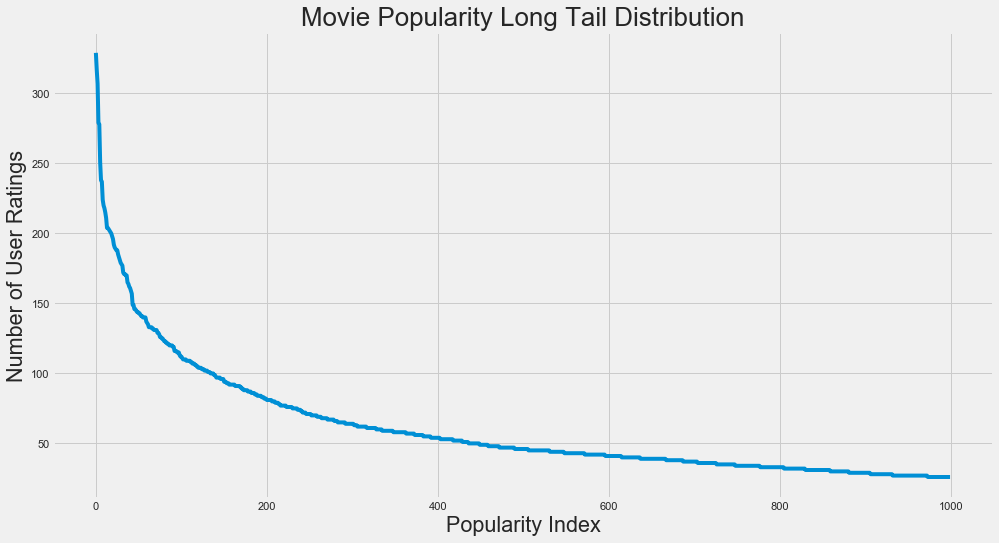

In [63]:
plt.figure(figsize=(15,8))
plt.plot(xax, pc)
plt.xlabel('Popularity Index')
plt.ylabel('Number of User Ratings')
plt.title('Movie Popularity Long Tail Distribution')
plt.show()

*Observations:*

The Popularity of Movies follow the long tail distibution which exemplifies the phenomenon of rich gets richer. More Popular movies get more ratings.

The need for Recommender Systems are represented by a concept called the "Long Tail," which is visualized in the figure above. In the context of movies, there are some movies that everyone is going to watch: A-list movies, superheroes etc. There are also movies that are far more obscure: indies and foreign films, low budget flicks etc. Recommendation systems are made to help consumers tap into this long tail to assist them in picking from the endless number of options that are made available to them via the internet.

### Plot EDA
We downloaded plot summaries for all of our films and will take a look at what we find in them here

In [64]:
#Download toolkits
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/Bryan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Bryan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
#Create stop words
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

In [66]:
def black_txt(token):
    '''This function removes tokens that are in our stop words and punctuation'''
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
    '''This function cleans our text'''
    clean_text = []
    clean_text2 = []
    text = re.sub("'", "",text)
    text=re.sub("(\\d|\\W)+"," ",text) 
    text = text.replace("nbsp", "")
    clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    return " ".join(clean_text2)

In [67]:
nlp_df['plot'] = nlp_df['plot'].astype(str)
nlp_df['plot'] = nlp_df['plot'].apply(clean_txt)

In [68]:
#Looking at our dataframe
nlp_df.head()

,movieId,title,genres,imdbId,tmdbId,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...


In [69]:
nlp_df = nlp_df.dropna()

Now lets make some wordclouds from the plot of the movies for 4 star or higher, average films, and below 2.75 star ratings!

In [70]:
word_cloud_df=nlp_df.merge(ratings_df.groupby('movieId')['rating'].mean(),how='left',on='movieId')
word_cloud_df.shape

(9594, 7)

In [71]:
#Splitting the dataframes into top movies with a ranking of 4.5 or higher
#low rated movies with average rating 2.5 or lower and average movies

low_df = word_cloud_df[word_cloud_df['rating'] <= 2.75]
top_df = word_cloud_df[word_cloud_df['rating'] >= 4]
avg_df = word_cloud_df[word_cloud_df['rating']>2.75]
avg_df =avg_df[avg_df['rating'] < 4]
low = " ".join(plot for plot in low_df['plot'])
top = " ".join(plot for plot in top_df['plot'])
avg = " ".join(plot for plot in avg_df['plot'])

Checking the sizes of the rankings bucket

In [72]:
print('There are', top_df.shape[0], 'top films')
print('There are', low_df.shape[0], 'low rated films')
print('There are', avg_df.shape[0], 'average films')

There are 2207 top films
There are 2362 low rated films
There are 5007 average films


In [73]:
def wordcloud(text,colormap='Blues',interpolation = 'bilinear'):
    '''This function takes in text and outputs a wordcloud. Option
    arguments are colormap and interpolation '''
    wordcloud = WordCloud(width=1080, height=720, colormap=colormap).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation=interpolation)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

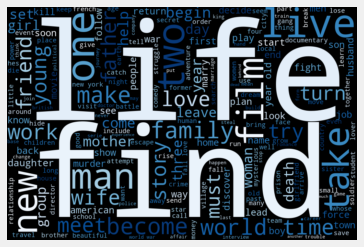

In [74]:
#Top rated wordcloud
wordcloud(top)

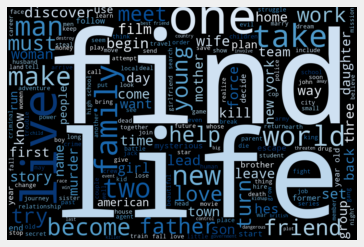

In [75]:
#Average rated wordcloud
wordcloud(avg)

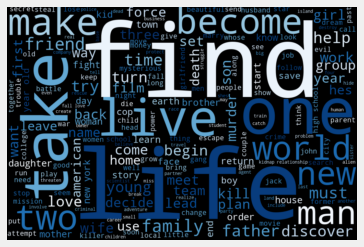

In [76]:
#Low rated wordcloud
wordcloud(low)

Looking at the wordclouds it seems like many of the words are the same across the ratings buckets. It is likely that our classification models will do a poor job if the words are similar.

## Train Test Split Data

In [77]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot,ratedYear
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2000
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",1996
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2005
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2017
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2011


In [78]:

reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(df[['userId','title','rating']], reader)
trainset, testset = surprise.model_selection.train_test_split(data, test_size=.25, random_state=42)

## Collaborative Filtering

### Item-Item Filtering


The Pivot table created below is used to map 1:1 relationship between movies, users and their ratings. By default, the pivot_table method takes average if there are multiple values of one combination.

In [79]:
ratings_matrix_items = df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna(0, inplace = True )
ratings_matrix_items.shape

(9576, 610)

In [80]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
collab_matrix = ratings_matrix_items
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9573,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9574,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [82]:
ratings_matrix_items['movie'] = movies_df['title']
ratings_matrix_items.set_index('movie', inplace = True)


In [83]:
ratings_matrix_items.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9566,9567,9568,9569,9570,9571,9572,9573,9574,9575
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
ratings_matrix_items.columns = ratings_matrix_items.index
ratings_matrix_items

movie,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Seven Sisters (2017),Atomic Blonde (2017),Empties (2007),Goon: Last of the Enforcers (2017),Black Mirror: White Christmas (2014),Dunkirk (2017),Belladonna of Sadness (1973),The Putin Interviews (2017),Unedited Footage of a Bear (2014),Obsession (1965)
movie,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dunkirk (2017),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Belladonna of Sadness (1973),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
The Putin Interviews (2017),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [85]:
ratings_matrix_items.iloc[9].sort_values(ascending=False).head(6)

movie
Die Hard: With a Vengeance (1995)    0.615794
True Lies (1994)                     0.576175
Clear and Present Danger (1994)      0.573650
Speed (1994)                         0.571704
Batman (1989)                        0.563148
Stargate (1994)                      0.562580
Name: GoldenEye (1995), dtype: float64

In [200]:
# create a box to let user input movie name (need a space after book name)
user_movie = str(input("Give a movie name?"))

Give a movie name?Departed, The (2006)


In [201]:
# create a function to return top 5 recommendations based on given movie
def get_rec(user_movie,ratings_matrix_items):
    for i in ratings_matrix_items.index:
        if user_movie == i:
            return ratings_matrix_items[user_movie].sort_values(ascending= False)[1:6]

In [202]:
# show recommendation results
print('Top 5 movie recommendations for you:')
print(get_rec(user_movie,ratings_matrix_items))

Top 5 movie recommendations for you:
movie
Walking Tall (2004)             0.816497
New York, New York (1977)       0.816497
Seven Up! (1964)                0.816497
Employee of the Month (2006)    0.797241
Gas, Food, Lodging (1992)       0.707107
Name: Departed, The (2006), dtype: float64


#### Evaluation

In [89]:
# Try two similarity metrics
sim_pear = {'name':'pearson','user_based':False}
sim_cos = {'name':'cosine','user_based':False}

# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9761
0.9760820557139148


In [90]:
# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9676
0.9676092708427374


### User-User Filtering

In this method, we recommend movies to a user based on his preferences compared to preferences of other users. This algorithm is very effective but takes a lot of time and resources. 

In [91]:
ratings_matrix_users = df.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.028038,0.061712,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.081062,0.164455,0.221486,0.070669,0.156332,0.164341,0.269389,0.291341,0.093572,0.145766
1,0.028038,0.000000,0.000000,0.003829,0.017075,0.026035,0.028349,0.028012,0.000000,0.069313,...,0.209598,0.017333,0.012329,0.000000,0.000000,0.029243,0.013306,0.047530,0.028329,0.105586
2,0.061712,0.000000,0.000000,0.002326,0.005187,0.004068,0.000000,0.005106,0.000000,0.000000,...,0.005250,0.005055,0.025825,0.000000,0.011245,0.013439,0.019889,0.021852,0.000000,0.033292
3,0.194395,0.003829,0.002326,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.086481,0.128273,0.307973,0.052985,0.086074,0.200577,0.131746,0.149983,0.032198,0.108013
4,0.129080,0.017075,0.005187,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068477,0.418747,0.110148,0.258773,0.151379,0.106532,0.152866,0.135649,0.261232,0.060978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164341,0.029243,0.013439,0.200577,0.106532,0.102216,0.200217,0.099479,0.075967,0.089044,...,0.179372,0.116640,0.300943,0.066093,0.150889,0.000000,0.153202,0.263017,0.069685,0.201905
606,0.269389,0.013306,0.019889,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.093109,0.199910,0.203540,0.137834,0.120873,0.153202,0.000000,0.283318,0.149190,0.139541
607,0.291341,0.047530,0.021852,0.149983,0.135649,0.178959,0.323812,0.187390,0.100519,0.077488,...,0.159488,0.197679,0.232966,0.155436,0.181432,0.263017,0.283318,0.000000,0.122095,0.321602
608,0.093572,0.028329,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035878,0.335231,0.061941,0.236601,0.099330,0.069685,0.149190,0.122095,0.000000,0.053389



Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [92]:
ratings_matrix_users.idxmax(axis=1)

0      265
1      365
2      312
3      390
4      469
      ... 
605    473
606    569
607    479
608    339
609    248
Length: 610, dtype: int64

In [93]:
ratings_matrix_users.idxmax(axis=1).sample( 10, random_state = 42)

81     437
218    238
55      93
598    413
264    201
155    274
482     67
321    329
580    299
291     20
dtype: int64

In [94]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head(5)

,similarUser
0,265
1,365
2,312
3,390
4,469


The function belows takes in a user id then looks at the similarUser dataframe to check the most similar user. Then this automatically outputs n recommendations that are highly-rated by the similar user.

In [95]:
def similar_user_rec(user_id,n=5):
    '''The function belows takes in a user id then looks at the similarUser dataframe to check the most similar user. Then this automatically outputs five recommendations that are highly-rated by the similar user.'''
    similar_user = df_similar_user['similarUser'].iloc[user_id]
    new_df = df.loc[(df['userId'] == similar_user)]
    new_df = new_df.sort_values('rating', ascending=False).head(n)
    rec_list = new_df['title'].to_list()
    print("Based on users with similar tastes, you will also like the following movies:")
    return rec_list[0:n+1]

In [204]:
similar_user_rec(123,10)

Based on users with similar tastes, you will also like the following movies:


['Brazil (1985)',
 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)',
 'Full Metal Jacket (1987)',
 'Chinatown (1974)',
 'Blade Runner (1982)',
 'Taxi Driver (1976)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
 'Memento (2000)',
 'Dark Knight Rises, The (2012)',
 'Dark Knight, The (2008)']

#### Evaluation

In [97]:
# Try two similarity metrics
sim_pear = {'name':'pearson','user_based':True}
sim_cos = {'name':'cosine','user_based':True}

# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9746
0.974607476667081


In [98]:
# Fit the model using KNN 
basic = knns.KNNBasic(sim_options=sim_pear)
basic.fit(trainset)
predictions_knn = basic.test(testset)
print(accuracy.rmse(predictions_knn))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9781
0.9780775502385187


### Memory-Based Methods (Neighborhood-Based)

The first thing we are going to do is build some baseline Collaborative Recommendation models. We will begin with Surprise and loading in our data. We'll first look at RMSE for evaluation but then expand to a hit rate metric.

In [99]:
ratings_df.drop(columns='timestamp',inplace=True)
reader = surprise.Reader(rating_scale=(1, 5))
data = surprise.Dataset.load_from_df(ratings_df, reader)

Let's look at how many users and items we have in our dataset.

In [100]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [101]:
#Creating SVD Model and showing RMSE
params = {'n_epochs': [5,10,20],
          'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(surprise.SVD,param_grid=params,n_jobs=1)
g_s_svd.fit(data)
print(g_s_svd.best_score)
print(g_s_svd.best_params)


{'rmse': 0.8691952873630104, 'mae': 0.6683152442088344}
{'rmse': {'n_epochs': 20, 'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_epochs': 20, 'n_factors': 100, 'reg_all': 0.05}}


The best SVD model for gridsearch resulted in an RMSE of 0.869 and a MAE of .67.

In [102]:
sim_metrics = ['pearson','MSD','cosine','pearson_baseline']
#Creating Basic KNN Model and showing RMSE, checking all distance metrics
for metric in sim_metrics:
    knn_basic = surprise.KNNBasic(sim_options={'name': metric, 'user_based':True})
    cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_basic['test_rmse']),'\n')
    
    

Similarity Metric =  pearson --- test_rmse =  0.9725753055767565 

Similarity Metric =  MSD --- test_rmse =  0.9458180212727836 

Similarity Metric =  cosine --- test_rmse =  0.9716427242934669 

Similarity Metric =  pearson_baseline --- test_rmse =  0.9727387993885728 



The basic KNN model performed worse than the SVD model across all similarity metrics

In [103]:
# cross validating with KNNBaseline
for metric in sim_metrics:
    knn_baseline = surprise.KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
    cv_knn_baseline = cross_validate(knn_baseline,data)
    print('Similarity Metric = ', metric,'---', 'test_rmse = ', np.mean(cv_knn_baseline['test_rmse']),'\n')

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Similarity Metric =  pearson --- test_rmse =  0.8769374660605568 

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matri

The KNN Baseline model results in RMSE values are similar to the SVD  model so we will look at a hit rate method for evaluation.

#### Hit rate as an evaluation
The hit rate method for evaluation takes the set of model outputs and then predicts n movies that they will have rated. Everytime a predicted movie appears in the actual list we will mark it as a hit. We will look at this both by rating and cumulatively to evaluate our KNN and SVD models.

In [104]:
#Get top N predictions for ratings above minRating
def GetTopN(predictions, n=10, minRating=4.0):
    '''This function takes in model predictions, top n as an integer, and the minimum rating we care about and outputs the predicted topN entries'''
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN
    
LOOCV = LeaveOneOut(n_splits=1, random_state=1)



In [105]:
def HitRate(topNPredicted, leftOutPredictions):
    '''Inputs the predicted n recs and the actual recs to calcualate hit rate by rating'''
    hits = defaultdict(float)
    total = defaultdict(float)
    # For each left-out rating
    for userID, leftOutMovieID, actualRating, estimatedRating, _ in leftOutPredictions:
        # Is it in the predicted top N for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == movieID):
                hit = True
                break
        if (hit) :
            hits[actualRating] += 1
        total[actualRating] += 1

    # Compute overall precision
    for rating in sorted(hits.keys()):
        print(rating, hits[rating] / total[rating])

In [106]:
#Split into train and test sets
trainSet, testSet = surprise.model_selection.train_test_split(data, test_size=.25, random_state=0)



In [107]:
#Get top predictions 
#When I use n=10 for knn it gets 0 hits, expanding to 50 it got a positive non-zero amount
#so I am confident it is working just doing a worse job likely due to sparseness. I expanded
#both to 50 for now
svd_model= surprise.SVD(n_factors=50,reg_all=0.05)
KNN_model= surprise.KNNBaseline(sim_options={'name':'pearson', 'user_based':True})

for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd_model.fit(trainSet)
    leftOutPredictionsSVD = svd_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsSVD = svd_model.test(bigTestSet)
    
    KNN_model.fit(trainSet)
    leftOutPredictionsKNN = KNN_model.test(testSet)
    bigTestSet = trainSet.build_anti_testset()
    allPredictionsKNN = KNN_model.test(bigTestSet)
   
  
  

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [108]:
n=50
minrating=2
# Compute top 50 recs for each user
topNPredictedSVD = GetTopN(allPredictionsSVD, n, minrating)
topNPredictedKNN = GetTopN(allPredictionsKNN, n, minrating)

In [109]:
print("Hit Rate by Rating value SVD: ")
HitRate(topNPredictedSVD, leftOutPredictionsSVD)

Hit Rate by Rating value SVD: 
2.5 0.06666666666666667
3.0 0.034782608695652174
3.5 0.0625
4.0 0.10555555555555556
4.5 0.20754716981132076
5.0 0.17886178861788618


In [110]:
print("Hit Rate by Rating value KNN: ")
HitRate(topNPredictedKNN, leftOutPredictionsKNN)

Hit Rate by Rating value KNN: 
4.0 0.005555555555555556
5.0 0.008130081300813009


Its pretty clear that the SVD model is outperforming the KNN model here. It was slightly better using RMSE and is significantly better using a hit rate method. We will use the SVD model for the collaborative filtering portion of our hybrid model.

## Content-Based Filtering

In the resulting dataframe after running multiple API calls, we are able to get the plot of each movie. This section aims to build an accurate model that makes recommendation based on plot similarities.

### Bag of Words

Using our cleaned plot tokens we will create a bag of words count and use this to compute a cosine similarity matrix to recommend films

In [111]:
count = CountVectorizer()
count_matrix = count.fit_transform(nlp_df['plot'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.04222003 0.         ... 0.         0.02401461 0.        ]
 [0.04222003 1.         0.04767313 ... 0.         0.02585438 0.02132007]
 [0.         0.04767313 1.         ... 0.05270463 0.         0.04472136]
 ...
 [0.         0.         0.05270463 ... 1.         0.         0.        ]
 [0.02401461 0.02585438 0.         ... 0.         1.         0.02425356]
 [0.         0.02132007 0.04472136 ... 0.         0.02425356 1.        ]]


In [112]:
count_matrix.shape

(9594, 25578)

In [113]:
indices = pd.Series(nlp_df['title'])

In [114]:
def recommend(title,n=5, cosine_sim = cosine_sim):
    '''This function takes in a title and number n and outputs n recommendations '''
    recommended_movies = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_n_indices = list(score_series.iloc[1:n+1].index)
    
    for i in top_n_indices:
        recommended_movies.append(list(nlp_df['title'])[i])
        
    return recommended_movies

In [115]:
n=10
recommend('Departed, The (2006)',n)

['Jack the Bear (1993)',
 'Serial Mom (1994)',
 'Vacation (2015)',
 'Sabrina (1954)',
 'Rocco and His Brothers (Rocco e i suoi fratelli) (1960)',
 'Kramer vs. Kramer (1979)',
 'Princess Diaries 2: Royal Engagement, The (2004)',
 'Dark Skies (2013)',
 'Great Outdoors, The (1988)',
 'Texas Chainsaw Massacre: The Next Generation (a.k.a. The Return of the Texas Chainsaw Massacre) (1994)']

### TF-IDF Models
In this section we will calculate TF_IDF and then use various models to see whether we can accurately classify movies into their potental ratings bucket. Note that in the Plot EDA section we show where we created the buckets

Now we will build some classification models to see if they can group the ratings into the top, low, and average categories

In [116]:
#convert into categories
word_cloud_df['category'] = word_cloud_df['rating'].apply(lambda x: 'top' if x>=4.5 else ('low' if x<=2.5 else 'avg'))



In [117]:
word_cloud_df.head()

,movieId,title,genres,imdbId,tmdbId,plot,rating,category
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...,3.920930,avg
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...,3.431818,avg
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...,3.259615,avg
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...,2.357143,low
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...,3.071429,avg


In [118]:
word_cloud_df['plot'][0]

'lead woody andys toy live happily room andys birthday bring buzz lightyear onto scene afraid lose place andys heart woody plot buzz circumstances separate buzz woody owner duo eventually learn put aside differences'

In [119]:
n=0
for row in word_cloud_df['genres']:
    genre_list = row.split('|')
    word_cloud_df['plot'][n]+=' '
    for item in genre_list:
        word_cloud_df['plot'][n]+=item
        word_cloud_df['plot'][n]+=' '
    n+=1

In [120]:
word_cloud_df['plot'][0]

'lead woody andys toy live happily room andys birthday bring buzz lightyear onto scene afraid lose place andys heart woody plot buzz circumstances separate buzz woody owner duo eventually learn put aside differences Adventure Animation Children Comedy Fantasy '

In [121]:
#use plot as the features, category as the output
X = word_cloud_df['plot']
y = word_cloud_df['category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 13)

categories = ['top', 'avg', 'low']


First we will make a naive bayes classifier

In [122]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.7092235539343408
              precision    recall  f1-score   support

         top       0.71      1.00      0.83      1361
         avg       0.00      0.00      0.00       417
         low       0.00      0.00      0.00       141

    accuracy                           0.71      1919
   macro avg       0.24      0.33      0.28      1919
weighted avg       0.50      0.71      0.59      1919

avg    1919
dtype: int64


In [123]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[   0,  141,    0],
       [   0, 1361,    0],
       [   0,  417,    0]])

The naive bayes classifier simply labeled everything as average. Not a good outcome. Next we'll try a logistic regression classifier.

In [124]:

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=1e5)),
               ])
logreg.fit(X_train, y_train)


y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.6294945284002085
              precision    recall  f1-score   support

         top       0.72      0.81      0.76      1361
         avg       0.28      0.23      0.25       417
         low       0.17      0.06      0.09       141

    accuracy                           0.63      1919
   macro avg       0.39      0.37      0.37      1919
weighted avg       0.59      0.63      0.60      1919

avg    1527
low     345
top      47
dtype: int64


In [125]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[   8,  112,   21],
       [  29, 1104,  228],
       [  10,  311,   96]])

The logistic had a the highest overall accuracy by a small amount and it did classify into each of the ratings buckets! Finally, we'll look at a SGD classifier.

In [126]:
#SVG with SGD
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='log', penalty='l2',alpha=.001, random_state=13, max_iter=1000)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))
print(pd.Series(y_pred).value_counts())

accuracy 0.7092235539343408
              precision    recall  f1-score   support

         top       0.71      1.00      0.83      1361
         avg       0.00      0.00      0.00       417
         low       0.00      0.00      0.00       141

    accuracy                           0.71      1919
   macro avg       0.24      0.33      0.28      1919
weighted avg       0.50      0.71      0.59      1919

avg    1919
dtype: int64


In [127]:
confusion_matrix(y_test, y_pred, labels=categories)

array([[   0,  141,    0],
       [   0, 1361,    0],
       [   0,  417,    0]])

We can see that the SVD and Naive Bayes models both simply classified everything as an average rating. The Logistic model performed better but still not great. It seems that using plot alone to differentiate the rating is not particularly helpful. Next we will look at a simple neural net model for classification into categories.




In [128]:
nn_df = nlp_df.merge(ratings_df)
nn_df.drop(columns=['imdbId','tmdbId','genres'],inplace=True)
nn_df.head()

,movieId,title,plot,userId,rating
0,1,Toy Story (1995),lead woody andys toy live happily room andys b...,1,4.0
1,1,Toy Story (1995),lead woody andys toy live happily room andys b...,5,4.0
2,1,Toy Story (1995),lead woody andys toy live happily room andys b...,7,4.5
3,1,Toy Story (1995),lead woody andys toy live happily room andys b...,15,2.5
4,1,Toy Story (1995),lead woody andys toy live happily room andys b...,17,4.5


In [129]:

# Raw text complaints
plot = word_cloud_df['plot'] 

# Initialize a tokenizer 
tokenizer = Tokenizer(num_words=20000) 

# Fit it to the complaints
tokenizer.fit_on_texts(plot) 

# Generate sequences
sequences = tokenizer.texts_to_sequences(plot) 
print('sequences type:', type(sequences))

# Similar to sequences, but returns a numpy array
one_hot_results= tokenizer.texts_to_matrix(plot, mode='binary') 
print('one_hot_results type:', type(one_hot_results))

# Useful if we wish to decode (more explanation below)
word_index = tokenizer.word_index 

# Tokens are the number of unique words across the corpus
print('Found %s unique tokens.' % len(word_index)) 

# Our coded data
print('Dimensions of our coded results:', np.shape(one_hot_results)) 

sequences type: <class 'list'>
one_hot_results type: <class 'numpy.ndarray'>
Found 25576 unique tokens.
Dimensions of our coded results: (9594, 20000)


In [130]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])

In [131]:
rating = word_cloud_df['category']

# Initialize
le = preprocessing.LabelEncoder() 
le.fit(rating)
print('Original class labels:')
print(list(le.classes_))
print('\n')
rating_cat = le.transform(rating)  

# If you wish to retrieve the original descriptive labels post production
# list(le.inverse_transform([0, 1, 3, 3, 0, 6, 4])) 

print('New rating labels:')
print(rating_cat)
print('\n')

# Each row will be all zeros except for the category for that observation 
print('One hot labels; 3 class columns, one for each of the categories.') 
rating_onehot = to_categorical(rating_cat)
print(rating_onehot)
print('\n')

print('One hot labels shape:')
print(np.shape(rating_onehot))

Original class labels:
['avg', 'low', 'top']


New rating labels:
[0 0 0 ... 0 0 0]


One hot labels; 3 class columns, one for each of the categories.
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


One hot labels shape:
(9594, 3)


In [132]:
random.seed(13)
test_index = random.sample(range(1,9594), 1500)

test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)

label_test = rating_onehot[test_index]
label_train = np.delete(rating_onehot, test_index, 0)

print('Test label shape:', np.shape(label_test))
print('Train label shape:', np.shape(label_train))
print('Test shape:', np.shape(test))
print('Train shape:', np.shape(train))

Test label shape: (1500, 3)
Train label shape: (8094, 3)
Test shape: (1500, 20000)
Train shape: (8094, 20000)


In [133]:
# Initialize a sequential model
model = models.Sequential()

# Two layers with relu activation
model.add(layers.Dense(50, activation='relu', input_shape=(20000,)))
model.add(layers.Dense(25, activation='relu'))

# One layer with softmax activation 
model.add(layers.Dense(3, activation='softmax'))
# Compile the model
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [134]:
# Train the model 
history = model.fit(train,
                    label_train,
                    epochs=20,
                    batch_size=256)

Epoch 1/20
8094/8094 [==============================] - 1s 180us/step - loss: 1.0231 - accuracy: 0.7013
Epoch 2/20
8094/8094 [==============================] - 1s 140us/step - loss: 0.9011 - accuracy: 0.7203
Epoch 3/20
8094/8094 [==============================] - 1s 142us/step - loss: 0.8313 - accuracy: 0.7203
Epoch 4/20
8094/8094 [==============================] - 1s 134us/step - loss: 0.7970 - accuracy: 0.7203
Epoch 5/20
8094/8094 [==============================] - 1s 122us/step - loss: 0.7799 - accuracy: 0.7203
Epoch 6/20
8094/8094 [==============================] - 1s 122us/step - loss: 0.7699 - accuracy: 0.7203
Epoch 7/20
8094/8094 [==============================] - 1s 118us/step - loss: 0.7631 - accuracy: 0.7203
Epoch 8/20
8094/8094 [==============================] - 1s 122us/step - loss: 0.7581 - accuracy: 0.7203
Epoch 9/20
8094/8094 [==============================] - 1s 117us/step - loss: 0.7540 - accuracy: 0.7203
Epoch 10/20
8094/8094 [==============================] - 1s 118u

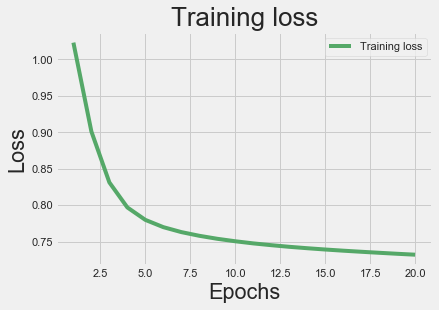

In [135]:
history_dict = history.history
loss_values = history_dict['loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

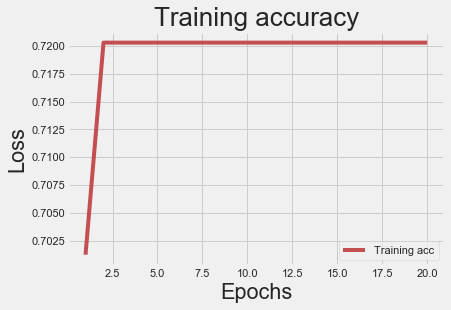

In [136]:
# Plot the training accuracy vs the number of epochs

acc_values = history_dict['accuracy'] 

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [137]:
# Output (probability) predictions for the test set 
y_pred = model.predict(test) 
y_labels = model.predict_classes(test)
# Print the loss and accuracy for the training set 
results_train = model.evaluate(train, label_train)
results_train

8094/8094 [==============================] - 1s 84us/step


[0.7311511005711961, 0.7202866077423096]

In [138]:
# Print the loss and accuracy for the test set 
results_test = model.evaluate(test, label_test)
results_test

1500/1500 [==============================] - 0s 74us/step


[0.7254391957918803, 0.734000027179718]

In [139]:
y_pred

array([[0.74504334, 0.17694244, 0.07801424],
       [0.78970766, 0.14736742, 0.06292488],
       [0.70797133, 0.2018759 , 0.09015276],
       ...,
       [0.6406845 , 0.25124335, 0.10807218],
       [0.6457176 , 0.25027075, 0.10401167],
       [0.64605993, 0.2443719 , 0.10956812]], dtype=float32)

In [140]:
y_labels

array([0, 0, 0, ..., 0, 0, 0])

We can see that this neural net model classified every film into the average category which is the same output as the Naive Bayes and SDG. I think we can definitely say that the plot is not a useful feature for predicting movie rating. We can still use plot as a similarity but it is not useful for prediciting the movie rating.

### Content-Based recommendations based on plot similiarity using TF-IDF

In [141]:
#Create a tf-idf vectorizer using unigrams and bi-grams
#As we have already cleaned the data we don't need stop works here
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
tfidf_matrix = tf.fit_transform(word_cloud_df['plot'])

In [142]:
#We get the cosine similarity matrix using the sklearn linear_kernal module
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
content_matrix = cosine_sim

In [143]:
tfidf_matrix.shape

(9594, 249995)

In [144]:
content_matrix.shape

(9594, 9594)

In [145]:
df.head()

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot,ratedYear
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2000
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",1996
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2005
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2017
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2011


In [146]:
#using just the items we care about here
titles = word_cloud_df[['title','genres', 'plot', 'rating']]
indices = pd.Series(word_cloud_df.index, index=word_cloud_df['title'])

In [165]:
word_cloud_df.to_csv("word_df.csv")

### Content Rec
Below we will make recommendations based on similar plots from our film database.

In [185]:
def content_recommendations(title,n):
    '''This function takes in a title and a number of recs and outputs
    the number of closests films based on plot similarity'''
    idx = indices[title]
    sim_scores = list(enumerate(content_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movies = [i[0] for i in sim_scores]
    return titles.iloc[movies].sort_values('rating', ascending=False)

In [160]:
content_df = pd.DataFrame(content_matrix)
content_df.to_csv("content_matrix.csv")
content_df

,0,1,2,3,4,5,6,7,8,9,...,9584,9585,9586,9587,9588,9589,9590,9591,9592,9593
0,1.000000,0.014874,0.000733,0.000844,0.000928,0.003147,0.001118,0.005658,0.000000,0.001569,...,0.002658,0.008401,0.000455,0.004376,0.000000,0.017951,0.007277,0.000000,0.010620,0.001271
1,0.014874,1.000000,0.013148,0.001912,0.000000,0.014797,0.000000,0.011513,0.036192,0.003830,...,0.000000,0.000000,0.001031,0.000000,0.005354,0.002598,0.010333,0.000000,0.002508,0.007064
2,0.000733,0.013148,1.000000,0.011179,0.016285,0.000000,0.009003,0.002568,0.000000,0.000000,...,0.000598,0.003468,0.004352,0.000000,0.000000,0.006218,0.004528,0.005428,0.000000,0.015028
3,0.000844,0.001912,0.011179,1.000000,0.001147,0.009129,0.004192,0.003604,0.003225,0.000000,...,0.000689,0.001012,0.003919,0.000000,0.000000,0.000933,0.002814,0.001636,0.002742,0.003779
4,0.000928,0.000000,0.016285,0.001147,1.000000,0.000000,0.009500,0.000000,0.011718,0.000000,...,0.009132,0.000000,0.000618,0.013200,0.027781,0.001025,0.000591,0.000000,0.000000,0.001726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9589,0.017951,0.002598,0.006218,0.000933,0.001025,0.001527,0.001235,0.000000,0.004562,0.001362,...,0.019242,0.003963,0.002992,0.004835,0.000000,1.000000,0.017379,0.000000,0.013106,0.001405
9590,0.007277,0.010333,0.004528,0.002814,0.000591,0.005710,0.005723,0.001228,0.000000,0.018958,...,0.007837,0.010808,0.002948,0.009618,0.000000,0.017379,1.000000,0.000000,0.010095,0.000809
9591,0.000000,0.000000,0.005428,0.001636,0.000000,0.000000,0.000000,0.005395,0.000000,0.000000,...,0.000000,0.001846,0.000882,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
9592,0.010620,0.002508,0.000000,0.002742,0.000000,0.010206,0.000000,0.000000,0.013421,0.005681,...,0.018148,0.004144,0.001298,0.005055,0.000000,0.013106,0.010095,0.000000,1.000000,0.002064


In [206]:
content_recommendations('Departed, The (2006)',30)

,title,genres,plot,rating
664,Supercop 2 (Project S) (Chao ji ji hua) (1993),Action|Comedy|Crime|Thriller,crime wave sweep hong kong police call jessica...,5.000000
5033,Infernal Affairs (Mou gaan dou) (2002),Crime|Drama|Thriller,chan wing yan young police officer send underc...,4.333333
911,Goodfellas (1990),Crime|Drama,true story henry hill half irish half sicilian...,4.250000
3277,"Way of the Dragon, The (a.k.a. Return of the D...",Action|Crime,tang lung arrive rome help cousins restaurant ...,4.166667
2043,"Killing, The (1956)",Crime|Film-Noir,career criminal johnny clay recruit sharpshoot...,4.055556
2489,Ghost Dog: The Way of the Samurai (1999),Crime|Drama,african american mafia hit man model samurai o...,4.052632
3380,Johnny Handsome (1989),Crime|Drama,career criminal deform since birth give new fa...,4.000000
2447,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller,cop lose partner shoot gun smugglers mission c...,4.000000
5054,Mean Streets (1973),Crime|Drama,small time hood must choose among love friends...,4.000000
7805,Get the Gringo (2012),Action|Crime|Drama|Thriller,career criminal gibson nab mexican authorities...,3.833333


## Hybrid Models

We opted to build several Hybrid Models that combines Collaborative and Content-Based approach in order for us to address two main issues:
1. Cold Start
2. Sparsity

Cold Start happens when there is new users or items so there is not enough data to make recommendations. Sparsity because the number of movies is extremely large and it is almost impossible for most users to review all of the movies. 

### Hybrid Model 1

Our Hybrid Model 1 works as follows:
- Our model will recommend n movies based on the plot of the movies
- Then our best-performing collaborative-filtering model will predict the ratings of the n movies and sort them accordingly

We need to inputs to get recommendations. First is his/her user id then a movie he/she really likes.

In [170]:
from surprise import Reader, Dataset, SVD

In [207]:
def hybrid_rec(userid, favemovie,n):
    '''this takes in a userid, favemovie and n number of recs and outputs those in a sorted list'''
    rec_hybrid = content_recommendations(favemovie,n)
    svd = SVD(n_factors=50, reg_all= 0.05, random_state=150)
    trainset = data.build_full_trainset()
    svd.fit(trainset)
    for index, row in rec_hybrid.iterrows():    
        pred = svd.predict(userid, index)
        rec_hybrid.at[index, 'score'] = pred.est
    rec_hybrid = rec_hybrid.sort_values('score', ascending=False)
    return rec_hybrid

In [208]:
hybrid_rec(150, "Departed, The (2006)",15)

,title,genres,plot,rating,score
1121,Donnie Brasco (1997),Crime|Drama,fbi undercover agent infilitrates mob find ide...,3.740385,3.660090
5054,Mean Streets (1973),Crime|Drama,small time hood must choose among love friends...,4.000000,3.649718
5649,Infernal Affairs 2 (Mou gaan dou II) (2003),Action|Crime|Drama|Thriller,prequel mou gaan dou chan wing yan become unde...,3.000000,3.608013
219,"Jerky Boys, The (1995)",Comedy,two unemployed telephone pranksters decide use...,2.071429,3.554318
7805,Get the Gringo (2012),Action|Crime|Drama|Thriller,career criminal gibson nab mexican authorities...,3.833333,3.537672
4301,"Dancer Upstairs, The (2002)",Crime|Drama|Thriller,police detective south american country dedica...,3.833333,3.537672
6047,District 13 (Banlieue 13) (2004),Action|Crime|Sci-Fi,set ghettos paris undercover cop thug try infi...,3.800000,3.537672
5763,Hostage (2005),Action|Crime|Drama|Thriller,mafia accountant take hostage beat police offi...,3.050000,3.537672
8265,Cold Comes the Night (2013),Crime|Drama|Thriller,struggle motel owner daughter take hostage nea...,2.000000,3.537672
6227,"Wicker Man, The (2006)",Horror|Mystery|Thriller,sheriff investigate disappearance young girl s...,1.000000,3.537672


In [197]:
word_cloud_df

,movieId,title,genres,imdbId,tmdbId,plot,rating,category
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,lead woody andys toy live happily room andys b...,3.920930,avg
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497,8844.0,siblings judy peter discover enchant board gam...,3.431818,avg
2,3,Grumpier Old Men (1995),Comedy|Romance,113228,15602.0,family wed reignite ancient feud next door nei...,3.259615,avg
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885,31357.0,cheat mistreat step women hold breath wait elu...,2.357143,low
4,5,Father of the Bride Part II (1995),Comedy,113041,11862.0,george bank recover daughters wed receive news...,3.071429,avg
...,...,...,...,...,...,...,...,...
9589,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131.0,ciel learn aurora society rumor research bring...,4.000000,avg
9590,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030.0,ancient disboard riku angry young warrior inte...,3.500000,avg
9591,193585,Flint (2017),Drama,6397426,479308.0,woman deal toxic water scandal flint michigan ...,3.500000,avg
9592,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455.0,power users around world suddenly commit suici...,3.500000,avg


### Hybrid Model 2

Our Hybrid Model 2 works as follows:

- We have bucketed our movie list into four categories depending on its popularity 
- Popularity is calculated based on the number of reviews made on it
- Then we will aggregate cosine similarity scores of our content-based model (based on movie plot) and the best-performing collaborative-filtering model
- The aggregation of the similarity scores will depend on the popularity:
    - If very popular, 15% collaborative-filtering + 85% content-based
    - If popular, 25% collaborative-filtering + 75% content-based
    - If moderate, 35% collaborative-filtering + 65% content-based
    - If low, 50-50

In [ ]:
pop_df = df.copy()

In [ ]:
pop_df = pop_df.groupby('title', as_index=False).agg({'rating': ['mean','count']})
pop_df.columns = pop_df.columns.droplevel(0)

In [ ]:
pop_df.columns = ['Movie', 'Mean', 'Count']
pop_df = pop_df.sort_values('Count', ascending=False)

In [ ]:
pop_df.describe()

In [ ]:
for index, row in pop_df.iterrows():
    if (row['Count'] >= 100):
        pop_df.at[index, 'Popularity'] = 4
    elif (row['Count'] >= 50):
        pop_df.at[index, 'Popularity'] = 3
    elif (row['Count'] >= 10):
        pop_df.at[index, 'Popularity'] = 2
    else:
        pop_df.at[index, 'Popularity'] = 1

In [ ]:
pop_df.shape

In [ ]:
content_matrix

In [ ]:
content_matrix.shape

In [ ]:
collab_matrix.shape

In [ ]:
raw_matrix = np.zeros((len(pop_df['Movie']),len(pop_df['Movie'])))

In [ ]:
len(pop_df['Movie'])

In [ ]:
def create_hybrid_similarity(content_matrix,collab_matrix,popularity):
    '''This creates and returns the hybrid similarity matrix'''
    weights= [0,0]
    if popularity == 4:
        weights[0]=.15
    elif popularity ==3:
        weights[0]=.25
    elif popularity == 2:
        weights[0]=.35
    elif popularity == 1:
        weights[0]=.5
    weights[1]=1-weights[0]

    for row in range(0,len(pop_df['Movie'])):
        for column in range(0,len(pop_df['Movie'])):
            raw_matrix[row][column] = collab_matrix[row][column]*weights[0]+content_matrix[row][column]*weights[1]
    return raw_matrix

In [ ]:
raw_matrix = pd.read_csv("raw_matrix.csv")
raw_matrix = raw_matrix.to_numpy()
raw_matrix

In [ ]:
#pd.DataFrame(raw_matrix).to_csv("raw_matrix.csv")

In [157]:
df.to_csv("df.csv")

In [158]:
df

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId,plot,ratedYear
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2000
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",1996
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2005
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2017
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0,"Led by Woody, Andy's toys live happily in his ...",2011
...,...,...,...,...,...,...,...,...,...,...
100292,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller,118745,30948.0,"Ken O'Hara (Gary Daniels) is a ""Mindhunter"" - ...",2016
100293,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama,66806,90351.0,A yakuza gang gets driven out of Yokohama by a...,2016
100294,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller,798722,70193.0,Shin is a Japanese university student living a...,2017
100295,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller,1540011,351211.0,Students on a camping trip discover something ...,2017


This function takes in a title and number of recs, then it calls the create_hybrid_similarity function to weight based on popularity and then return the top n recs.

In [ ]:
def content_rec_hybrid_2(title,n):
    '''This function takes in a title and a number of recs and outputs
    the number of closests films based on plot similarity'''
    idx = indices[title]
    sim_scores = list(enumerate(raw_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]
    movies = [i[0] for i in sim_scores]
    return titles.iloc[movies].sort_values('rating', ascending=False)

In [ ]:
content_rec_hybrid_2('Departed, The (2006)',15)

In [ ]:
test = content_rec_hybrid_2('Jumanji (1995)',15)

In [ ]:
test.iloc[0].title

### Hybrid Model 3 

This model takes advantage of the LightFM python library. LightFM handles cold start problem very well because of its hybrid nature. LightFM uses item and user features for recommendation. When intersection is not found for new users, it will automatically fall back to content or collaborative models depending on the inherent characteristics of the dataset.

In [ ]:
df.shape

In [ ]:
interaction = ratings_df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
interaction.fillna(0, inplace = True )
interaction.shape

In [ ]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm= False, threshold = None):
    interactions = df.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [ ]:
interaction_matrix = create_interaction_matrix(df=ratings_df, user_col='userId', item_col = 'movieId', rating_col='rating')
interaction_matrix.head()
x = sparse.csr_matrix(interaction_matrix.values)
x.shape

In [ ]:
interaction_matrix

In [ ]:

movielens = fetch_movielens()

In [ ]:
item_features = movielens['item_features']
item_features
train = movielens['train']
test = movielens['test']

In [ ]:
# Set the number of threads; you can increase this
# if you have more physical cores available.
NUM_THREADS = 2
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

In [ ]:
# Let's fit a WARP model: these generally have the best performance.
model_collab = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Run 3 epochs and time it.
%time model_collab = model_collab.fit(x, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

In [ ]:
train_auc = auc_score(model_collab, x, num_threads=4).mean()
print('Collaborative filtering AUC: %s' % train_auc)
print("Train precision: %.4f" % precision_at_k(model_collab, x, k=15,num_threads=4).mean())

In [ ]:
movie_similarity = 1 - pairwise_distances( interaction_matrix.as_matrix(), metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_items = pd.DataFrame( movie_similarity )
y = sparse.csr_matrix(ratings_matrix_items.values)

In [ ]:
# Define a new model instance
model_hybrid = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
                no_components=NUM_COMPONENTS)

# Fit the hybrid model. Note that this time, we pass
# in the item features matrix.
model_hybrid = model_hybrid.fit(y,
                item_features=item_features,
                epochs=NUM_EPOCHS,
                num_threads=NUM_THREADS)

In [ ]:
# Don't forget the pass in the item features again!
train_auc = auc_score(model_hybrid,
                      y,
                      item_features=item_features,
                      num_threads=NUM_THREADS).mean()
print('Hybrid training set AUC: %s' % train_auc)

In [ ]:
def create_user_dict(y):
    user_id = list(y.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [ ]:
user_dict = create_user_dict(interaction_matrix)

In [ ]:
def create_item_dict(df, id_col, name_col):
    item_dict ={}
    for i in df.index:
        item_dict[(df.loc[i, id_col])] = df.loc[i, name_col]
    return item_dict

In [ ]:
product_dict = create_item_dict(df = df, id_col = 'movieId', name_col = 'title')

In [ ]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print(scores)

    return scores 

In [ ]:
rec_list = sample_recommendation_user(model = model_hybrid, 
                                      interactions = interaction, 
                                      user_id = 123, 
                                      user_dict = user_dict,
                                      item_dict = product_dict, 
                                      threshold = 4,
                                      nrec_items = 10,
                                      show = True)

## Make recommendations

In [ ]:
def movie_rec(movie_df,n_ratings=4, genre=None,n_recs=5):
    '''This function takes in the movies dataframe, number of new ratings, genre choice, and
    number of recommendations requested and returns that many reccomendations'''
    userID = 1000
    rating_list = []
    while n_ratings > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            n_ratings -= 1
    ratings_df2 = ratings_df.append(rating_list,ignore_index=True)
    new_data = Dataset.load_from_df(ratings_df2,reader)
    svd_model= SVD(n_factors=50,reg_all=0.05)
    svd_model.fit(new_data.build_full_trainset())
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
    list_of_movies = []
    for m_id in ratings_df2['movieId'].unique():
        list_of_movies.append( (m_id,svd_model.predict(1000,m_id)[3]))
    
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    for idx, rec in enumerate(ranked_movies):
            title = movies_df.loc[movies_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n_recs-= 1
            if n_recs == 0:
                break

In [ ]:
n_ratings=4
n_recs=10

In [ ]:
movie_rec(movies_df, n_ratings,'Comedy',n_recs)

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df, reader)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

In [ ]:
# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [ ]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

In [ ]:
#top_n